In [1]:
import pyvista as pv
from pyvista import themes
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
from experiment.scenario import *
from experiment_setup.exp_utrecht_10_492_594_v2_setup import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Setup

Set up experiment:

In [3]:
load_existing_experiment = True

if not load_existing_experiment:
    e = Experiment(experiment_name, experiment_dirpath, default_config, scenario_settings, scene_parts)

    print("\nSetting up experiment:")
    e.setup()
else:
    print("\nLoading existing experiment:")
    e = Experiment.load(experiment_dirpath / experiment_name, load_scenarios=True)


Loading existing experiment:

Loading experiment configuration ...
Initializing experiment ...
Loading scenarios ...
- 143 scenarios


# Functions

In [4]:
material_dict = {
    "0": "zero",
    "1": "one",
    "2": "two",
    "3": "three"
}


def full_stem(p: Path):
    return p.parent / p.stem


def rename_materials(obj_in_filepath: Path | str, obj_out_filepath: Path | str, mtllib_filename: str | None = None, material_dict: dict = material_dict):
    
    with open(obj_in_filepath, "r") as f:
        lines = f.readlines()
    
    done_changing_mtllib = False
    for i, line in enumerate(lines.copy()):
        if line.startswith("usemtl"):
            mat_name = line.split(" ", 1)[1][:-1]  # remove \n
            if mat_name in material_dict.values():
                print(f"Materials in {obj_in_filepath.name} were renamed previously.")
                return
            else:
                try:
                    lines[i] = f"usemtl {material_dict[mat_name]}\n"
                except KeyError:
                    raise KeyError(f"Found material {mat_name} is not listed in the mapping dictionary.")
        if mtllib_filename is not None and not done_changing_mtllib:
            if line.startswith("mtllib"):
                lines[i] = f"mtllib {mtllib_filename}\n"
                done_changing_mtllib = True
    
    with open(obj_out_filepath, "w", encoding="utf-8") as f:
        f.writelines(lines)


def copy_obj_files(e: Experiment, scenarios: list[int], identificatie: str, mtllib_filepath: Path | str | None = None, lod: int = 22, overwrite: bool = False) -> dict[int, str]:
    mtllib_filepath = Path(mtllib_filepath)
    
    obj_filename = identificatie + ".obj"
    obj_dst_dirpath = e.dirpath / "09_visualization" / identificatie / f"obj_{lod}"
    obj_dst_dirpath.mkdir(parents=True, exist_ok=True)
    obj_dst_filepaths = {}

    for s in scenarios:
        if lod == 12:
            obj_dirpath = full_stem(e[s].obj_output_lod12_filepath)
        elif lod == 13:
            obj_dirpath = full_stem(e[s].obj_output_lod13_filepath)
        elif lod == 22:
            obj_dirpath = full_stem(e[s].obj_output_lod22_filepath)
        
        obj_filepath = obj_dirpath / obj_filename
        obj_dst_filepath = obj_dst_dirpath / (f"{e[s].name}_lod_{lod}_{obj_filename}")
        obj_dst_filepaths[s] = obj_dst_filepath
        
        print(f"\nCopying from: {obj_filepath}")
        print(f"Copying to:   {obj_dst_filepath}")
        
        if overwrite or not obj_dst_dirpath.is_file():
            shutil.copy2(obj_filepath, obj_dst_filepath)
    
    if mtllib_filepath is not None:
        if overwrite or not mtllib_filepath.is_file():
            shutil.copy2(mtllib_filepath, obj_dst_dirpath)
    
    return obj_dst_filepaths

def render_model(
    obj_filepath: str | Path,
    mtllib_filepath: str | Path,
    
    pos: tuple[float] | list[float] | None = None,
    zoom: float | None = 1.2,
    off_screen: bool = True,
    notebook: bool = True,
    lighting: str = "three lights",
    window_size: tuple[int] = (500, 500),
    
    show: bool = False,
    
    png_filepath: str | None = None,
    scale: float = 1,
    transparent_background: bool = True,
    return_img: bool = True,
) -> np.ndarray | None:
    
    obj_filepath = Path(obj_filepath)
    mtllib_filepath = Path(mtllib_filepath)
    
    print(f"Rendering {obj_filepath.name} ...")
    
    plotter = pv.Plotter(off_screen=off_screen, notebook=notebook, lighting=lighting, window_size=window_size)
    plotter.theme = themes.DocumentProTheme()
    plotter.import_obj(obj_filepath, mtllib_filepath)

    if pos is not None:
        plotter.set_position(pos)
        plotter.set_focus((0, 0, 0))
        plotter.set_viewup((0, 0, 1))

    if zoom is not None:
        plotter.zoom_camera(zoom)
    
    plotter.enable_eye_dome_lighting()
    plotter.enable_parallel_projection()
    
    if show:
        plotter.show(jupyter_backend="static")
    
    if png_filepath is not None:
        img = plotter.screenshot(png_filepath, scale=scale, transparent_background=transparent_background)
    
    plotter.clear()
    del plotter
    
    if png_filepath is not None and return_img:
        return img


# Visualization

## Initialize Variables

In [5]:
lod = 22
identificatie = "NL.IMBAG.Pand.0344100000069160"
mtllib_filepath = Path(r"C:\Users\Florian\Data\city-to-scan-to-city\utrecht_10-492-594_v2\09_visualization\obj_materials_visualization.mtl")

obj_dirpath = e.dirpath / "09_visualization" / identificatie / f"obj_{lod}"
obj_filepaths = {s: obj_dirpath / (f"{e[s].name}_lod_{lod}_{identificatie}.obj") for s in range(132)}

png_dirpath = e.dirpath / "09_visualization" / identificatie / f"png_{lod}"
png_filepaths = {s: png_dirpath / (f"{e[s].name}_lod_{lod}_{identificatie}.png") for s in range(132)}

In [6]:
input_obj_src_dirpath = Path(fr"C:\Users\Florian\OneDrive - TUM\Universität\24\Master's Thesis\Data\Utrecht\3DBAG\OBJ\LOD{lod}\10-492-594-LoD{lod}-3D")
input_obj_src_filepath = input_obj_src_dirpath / (identificatie + ".obj")

input_obj_dirpath = obj_filepaths[0].parent
input_obj_filepath = input_obj_dirpath / (f"input_lod_{lod}_{identificatie}.obj")

## Copy Meshes and Rename Materials

Renaming of materials is required for PyVista to work, or more specifically, for the vtkOBJImporter to work: Geoflow outputs material names consisting of single numbers (0, 1, 2, 3) and the vtk library cannot handle these.

In [ ]:
# Copy OBJ files from reconstruction to visualization directory

obj_filepaths = copy_obj_files(e, list(range(132)), identificatie, mtllib_filepath)

In [7]:
# Rename materials in the OBJ files

mtllib_filename = mtllib_filepath.name

for obj_filepath in list(obj_filepaths.values()):
    rename_materials(obj_filepath, obj_filepath, mtllib_filename)

In [ ]:
# Copy input building model OBJ to visualization directory and rename materials

if not input_obj_filepath.is_file():
    shutil.copy2(input_obj_src_filepath, input_obj_filepath)
rename_materials(input_obj_filepath, input_obj_filepath, mtllib_filename)   

## Render Models

In [7]:
png_dirpath = e.dirpath / "09_visualization" / identificatie / f"png_{lod}"
png_dirpath.mkdir(exist_ok=True)

x = -0.45
y = -0.9
z = 0.9
pos = (x, y, z)

# Must be set outside the function call to `render_model`, apparently
pv.set_plot_theme(themes.DocumentProTheme())

In [ ]:
for s, obj_filepath in list(obj_filepaths.items())[96:132]:
    png_filepath = png_dirpath / (obj_filepath.stem + ".png")
    
    img = render_model(
        obj_filepath,
        mtllib_filepath,
        pos,
        show=True,
        png_filepath=png_filepath,
        return_img=False
    )

Rendering input_lod_22_NL.IMBAG.Pand.0344100000069160.obj ...


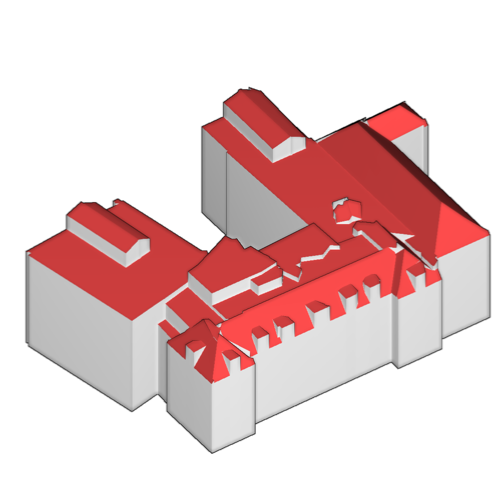

In [9]:
# Render input building model
obj_filepath = input_obj_filepath
png_filepath = png_dirpath / (obj_filepath.stem + ".png")
render_model(
    obj_filepath,
    mtllib_filepath,
    pos,
    show=True,
    # png_filepath=png_filepath,
    scale=2,
    return_img=False
)

In [8]:
# Render input building model
obj_filepath = input_obj_filepath
png_filepath = png_dirpath / (obj_filepath.stem + ".png")
render_model(
    obj_filepath,
    mtllib_filepath,
    pos,
    show=True,
    # png_filepath=png_filepath,
    scale=2,
    return_img=False,
    off_screen=False,
    notebook=False
)

Rendering input_lod_22_NL.IMBAG.Pand.0344100000069160.obj ...


c:\Users\Florian\miniconda3\envs\pyhelios_env_10\lib\site-packages\pyvista\plotting\plotter.py:6952: UserWarning: Not within a jupyter notebook environment.
Ignoring ``jupyter_backend``.
  warnings.warn(


### Render entire input dataset

In [7]:
utrecht_obj_src_filepath = r"C:\Users\Florian\OneDrive - TUM\Universität\24\Master's Thesis\Data\Utrecht\3DBAG\OBJ\LOD22\10-492-594-LoD22-3D.obj"
utrecht_mtl_src_filepath = r"C:\Users\Florian\OneDrive - TUM\Universität\24\Master's Thesis\Data\Utrecht\3DBAG\OBJ\LOD22\10-492-594-LoD22-3D.obj.mtl"

utrecht_obj_filepath = Path(r"C:\Users\Florian\OneDrive - TUM\Universität\24\Master's Thesis\Data\Utrecht\3DBAG\OBJ\LOD22\10-492-594-LoD22-3D_renamed_mtl.obj")
utrecht_mtl_filepath = Path(r"C:\Users\Florian\OneDrive - TUM\Universität\24\Master's Thesis\Data\Utrecht\3DBAG\OBJ\LOD22\10-492-594-LoD22-3D_renamed_mtl.obj.mtl")

png_filepath = str(utrecht_obj_filepath.parent / "10-492-594-LoD22-3D.png")

In [ ]:
rename_materials(utrecht_obj_src_filepath, utrecht_obj_filepath, "10-492-594-LoD22-3D_renamed_mtl.obj.mtl")

Rendering 10-492-594-LoD22-3D_renamed_mtl.obj ...


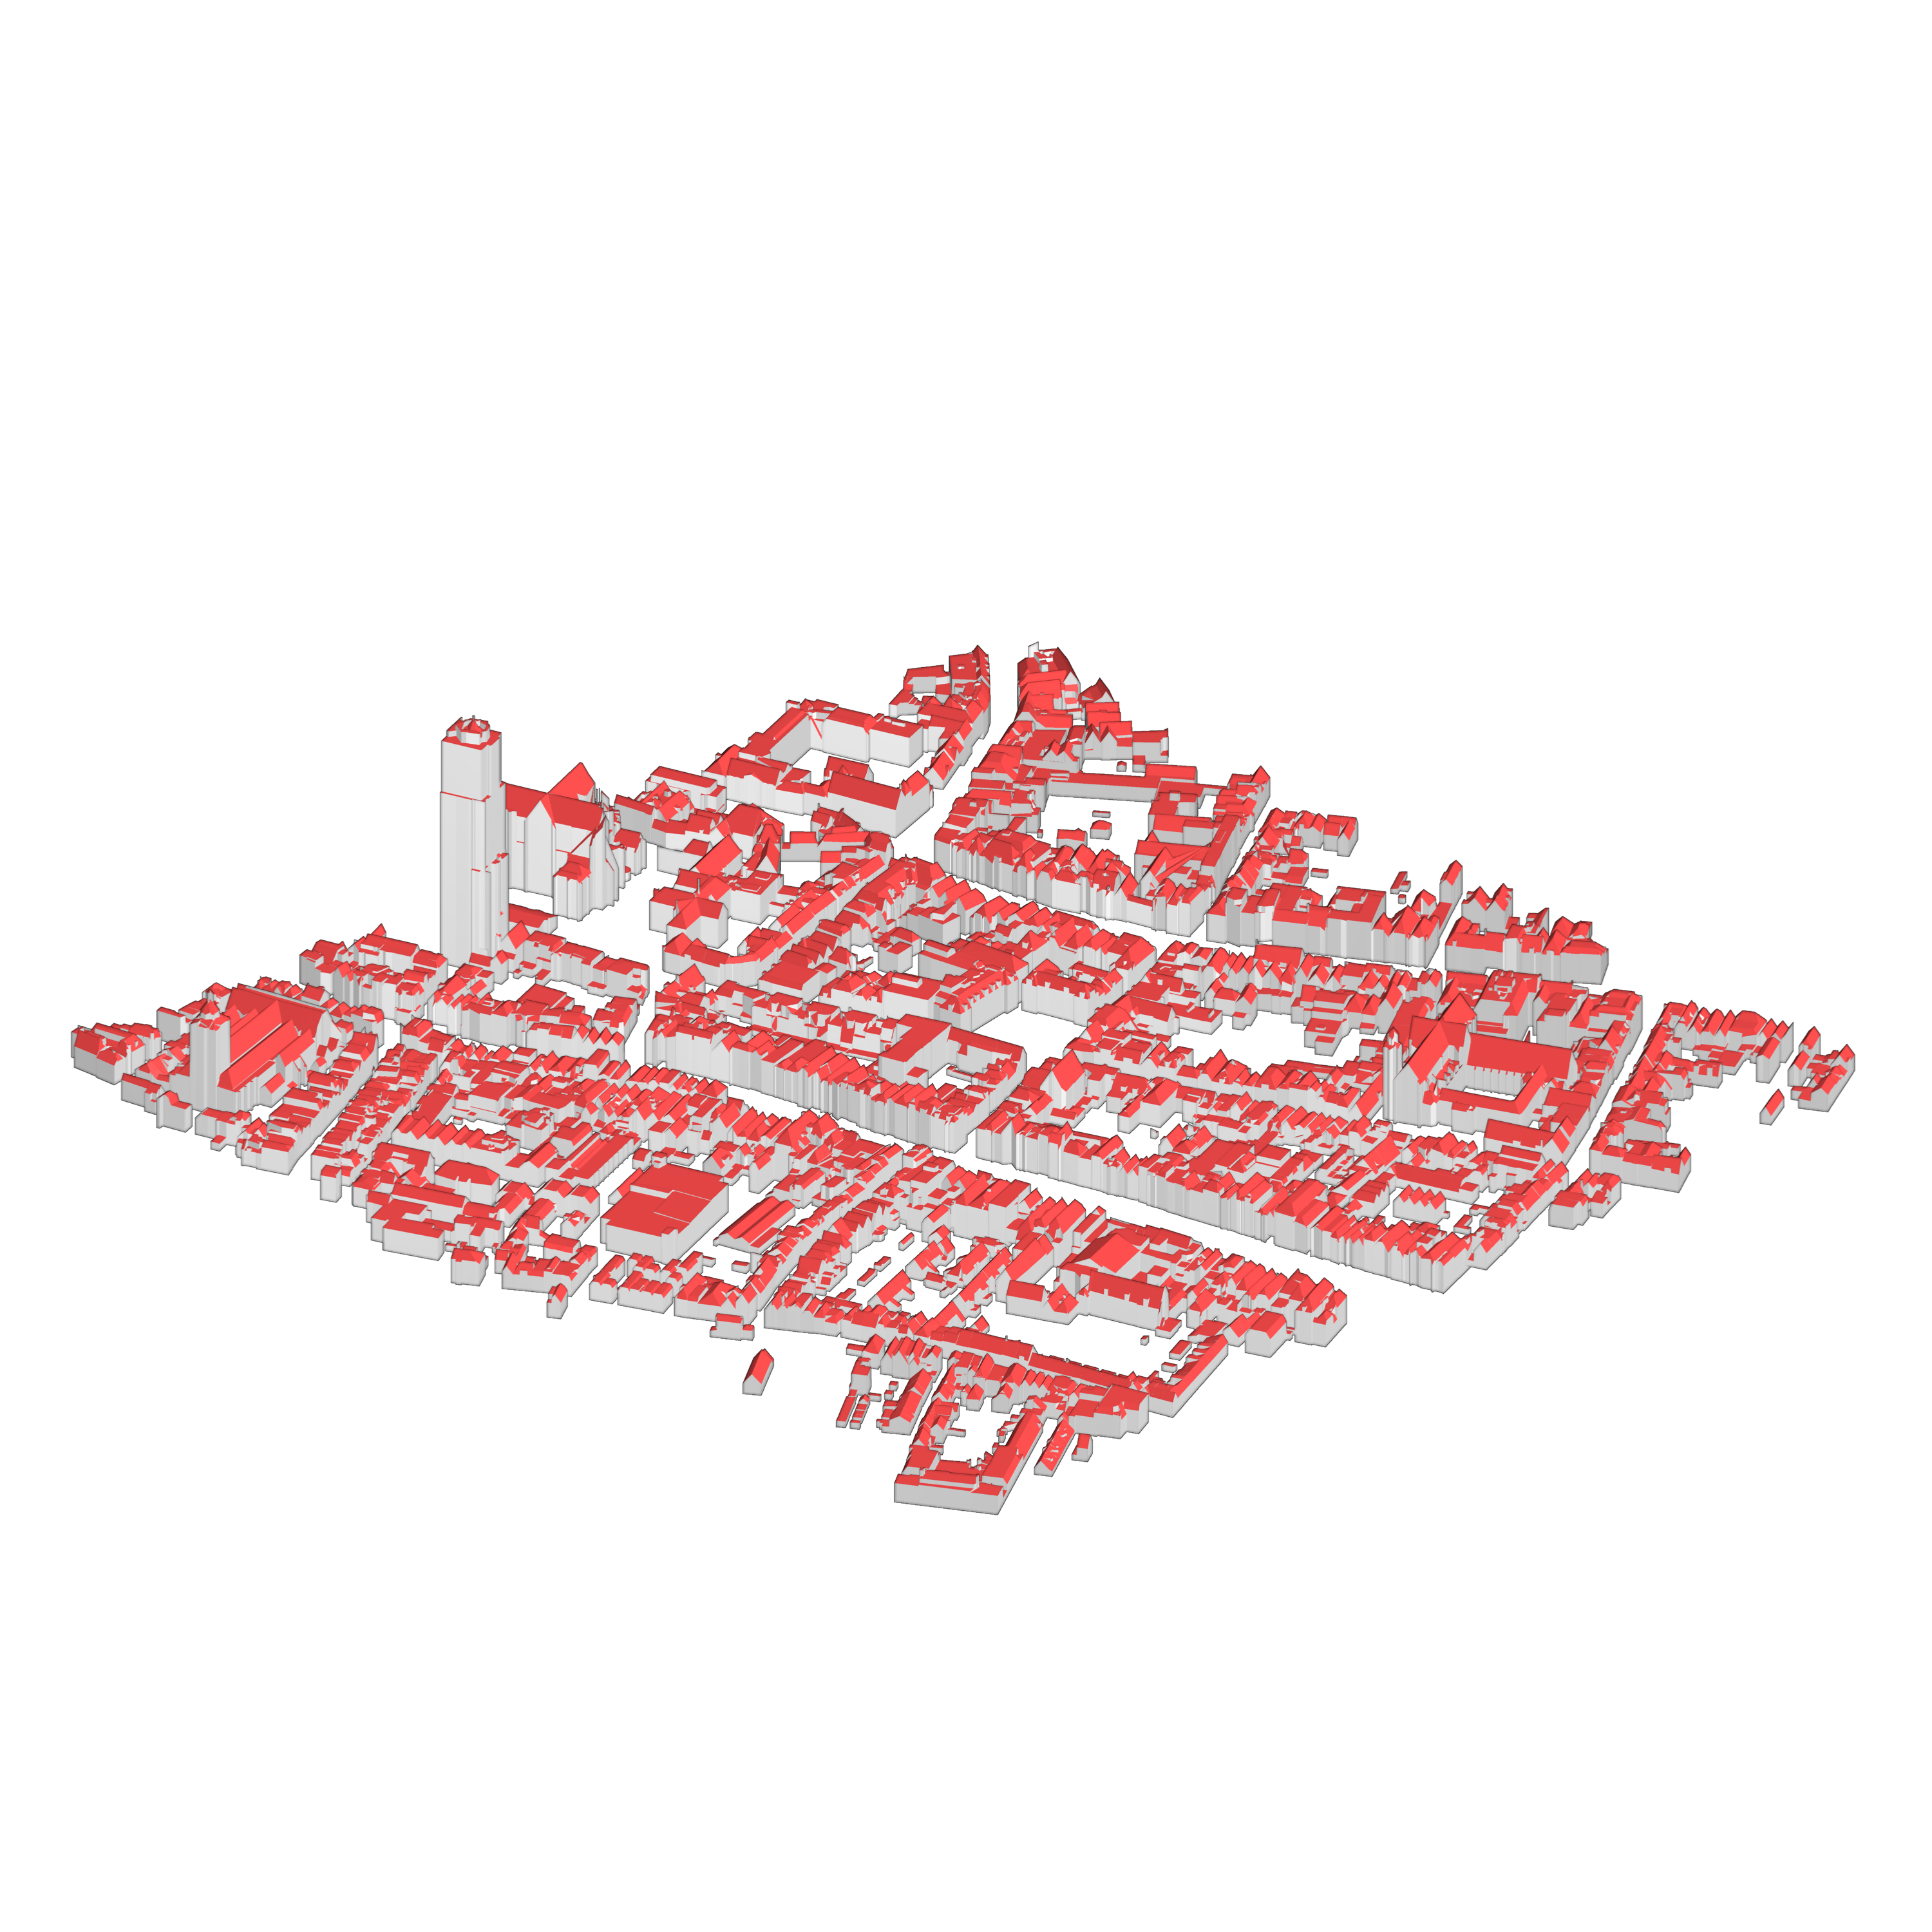

In [8]:
# x = -1
# y = -1
# z = 1

x = -1
y = -1
z = 0.75

pos = (x, y, z)

pv.set_plot_theme(themes.DocumentProTheme())

render_model(
    utrecht_obj_filepath,
    utrecht_mtl_filepath,
    pos=pos,
    show=True,
    png_filepath=png_filepath,
    return_img=False,
    window_size=(3000, 3000),
    zoom=None,
    scale=1,
    transparent_background=False
)

In [10]:
print("go")
plotter = pv.Plotter(off_screen=False, notebook=False, lighting="three lights", window_size=(1000, 1000))
plotter.theme = themes.DocumentProTheme()
plotter.import_obj(utrecht_obj_filepath, utrecht_mtl_filepath)
plotter.show()

go


## Plot Grid

In [7]:
e.load_final_results()

Loading evaluation results from file `evaluation_results.csv` ...


In [12]:
scenario_id = 66
scenario_name = f"scenario_{scenario_id:03}"
identificatie

'NL.IMBAG.Pand.0344100000069160'

In [13]:
e.results.index[0]

('scenario_000', 'NL.IMBAG.Pand.0344100000000004')

In [17]:
e.results.loc[(scenario_name, identificatie), "n_faces_22_ratio"]

1.5530546623794212

In [24]:
f"{e.results.loc[(scenario_name, identificatie), 'n_faces_22_ratio']:.3g}"

'1.55'

In [30]:
l = [2.0, 2.8, 4.0, 5.6, 8.0, 11.3, 16, 22.6, 32, 45.3, 64, 90.5]
for v in l:
    print(f"{v:.3g}")

2
2.8
4
5.6
8
11.3
16
22.6
32
45.3
64
90.5


[0, 11, 22, 33, 2, 13, 24, 35, 4, 15, 26, 37, 6, 17, 28, 39, 8, 19, 30, 41, 10, 21, 32, 43]


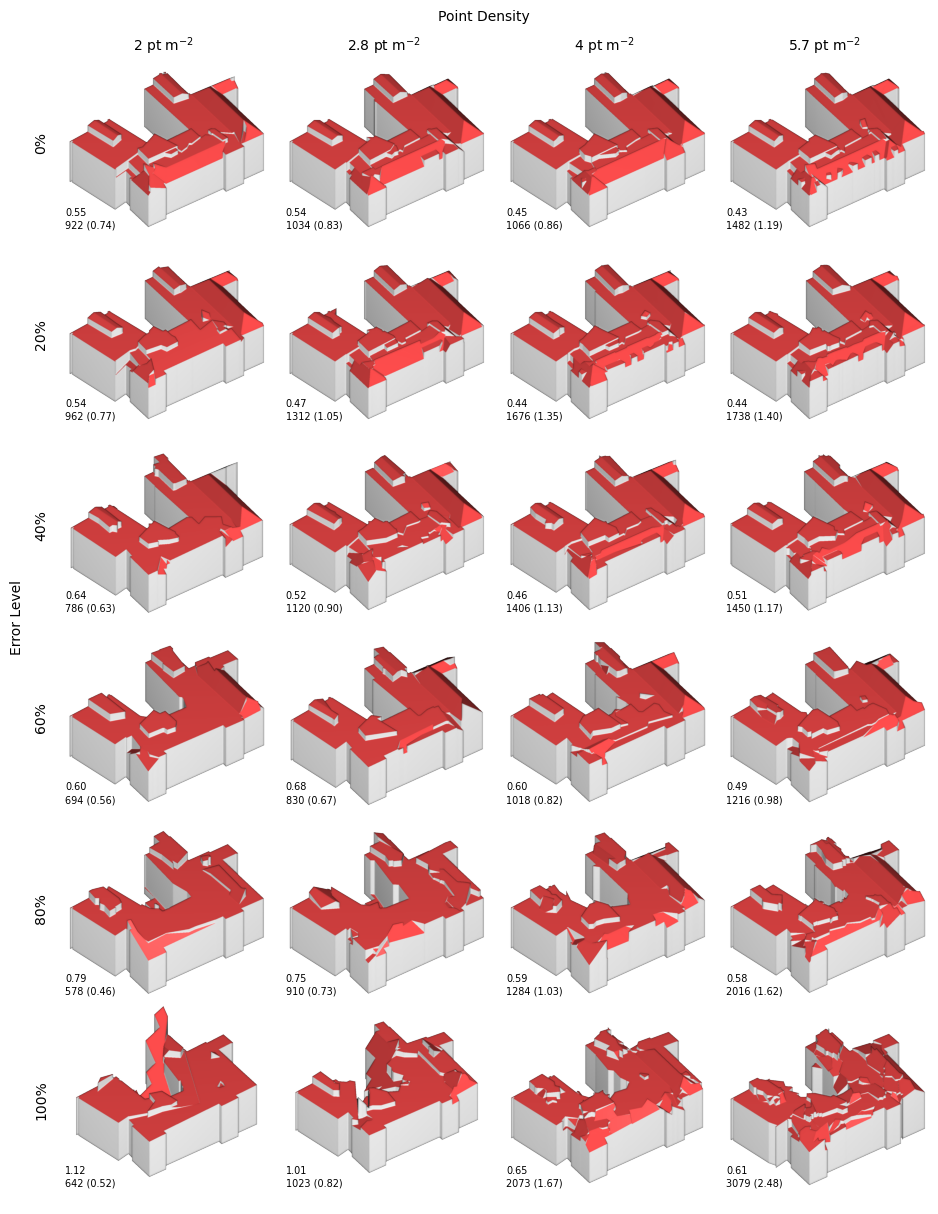

[44, 66, 88, 110, 46, 68, 90, 112, 48, 70, 92, 114, 50, 72, 94, 116, 52, 74, 96, 118, 54, 76, 98, 120]


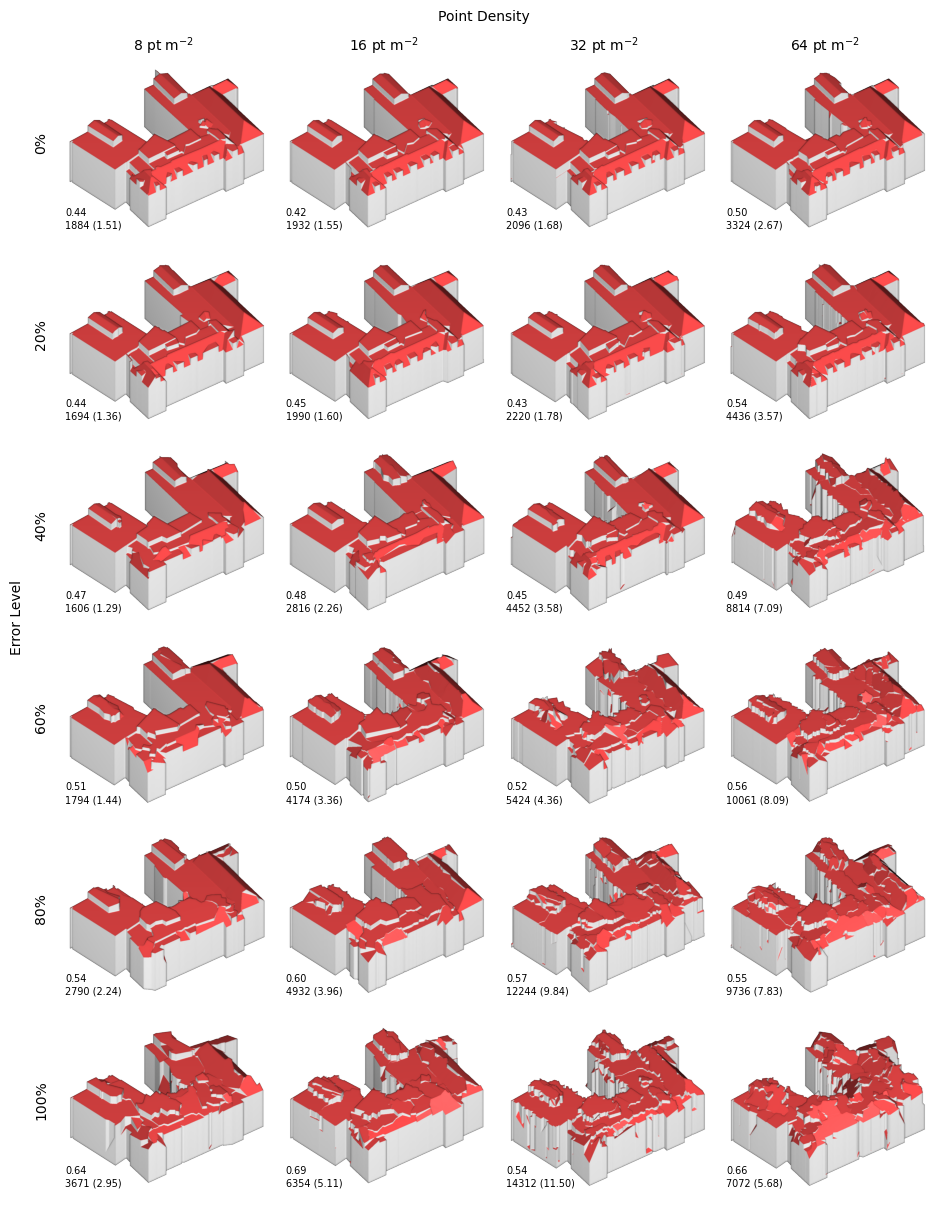

In [31]:
density_levels_ids = [0, 11, 22, 33, 44, 66, 88, 110]
error_levels_rel_ids = [0, 2, 4, 6, 8, 10]

density_levels_ids_1 = density_levels_ids[:4]
density_levels_ids_2 = density_levels_ids[4:]

density_levels_plots = [density_levels_ids_1, density_levels_ids_2]

col_width = 2.3
row_height = 2.3
label_fontsize = 10
transparent = False
draw_suptitle = True
draw_supylabel = True
draw_metrics = True
rotation_ylabel = 90

for f, density_levels_plot in enumerate(density_levels_plots):
    scenario_ids = [d+e for e in error_levels_rel_ids for d in density_levels_plot]
    print(scenario_ids)
    
    n_rows = len(error_levels_rel_ids)
    n_cols = len(density_levels_plot)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*col_width, n_rows*row_height))
    
    for i, ax in enumerate(axes.flat):
        scenario_id = scenario_ids[i]

        img = plt.imread(png_filepaths[scenario_id])
        ax.imshow(img)
        ax.set_axis_off()
        
        if draw_metrics:
            scenario_name = f"scenario_{scenario_id:03}"
            rms_min_dist_22 = e.results.loc[(scenario_name, identificatie), "rms_min_dist_22"]
            n_faces_22 = e.results.loc[(scenario_name, identificatie), "n_faces_22"]
            n_faces_22_ratio = e.results.loc[(scenario_name, identificatie), "n_faces_22_ratio"]
            
            ax.text(0.03, 0.14, f"{rms_min_dist_22:.2f}", ha="left", va="bottom", zorder=100, fontsize=7, transform=ax.transAxes)
            ax.text(0.03, 0.08, f"{n_faces_22:.0f} ({n_faces_22_ratio:.2f})", ha="left", va="bottom", zorder=100, fontsize=7, transform=ax.transAxes)

        if i < n_cols:
            point_density = np.round(2**((scenario_id//11)/2 + 1), decimals=1)
            point_density_str = f"{point_density:.3g}" + " pt m$^{-2}$"
            if not draw_suptitle:
                point_density_str = "Point Density: " + point_density_str
            # ax.text(-0.1, 0.5, point_density_str, va='center', ha='right', rotation=90, fontsize=label_fontsize, transform=ax.transAxes)
            ax.set_title(point_density_str, fontsize=label_fontsize, fontweight="normal", y=0.9)

        if i % n_cols == 0:
            error_level = int(scenario_id % 11 * 10)
            error_level_str = f"{error_level}%"
            if not draw_supylabel:
                error_level_str = "Error Level: " + error_level_str
            # ax.set_title(error_level_str, fontsize=label_fontsize, fontweight="normal")
            ax.text(-0.05, 0.5, error_level_str, va='center', ha='right', rotation=rotation_ylabel, fontsize=label_fontsize, transform=ax.transAxes)
    
    plt.tight_layout()
    fig.subplots_adjust(hspace=-0.5)
    
    if draw_suptitle:
        fig.suptitle("Point Density", y=0.94, fontsize=label_fontsize)
    if draw_supylabel:
        fig.supylabel("Error Level", x=-0.015, fontsize=label_fontsize)
    
    # fig.savefig(f"figures/models_3d_vis_6x4{ '_suplabels' * draw_suptitle}{ '_3metrics' * draw_metrics}{ '_transparent' * transparent }_{f}.png", dpi=200, bbox_inches="tight", transparent=transparent)
    
    plt.show()

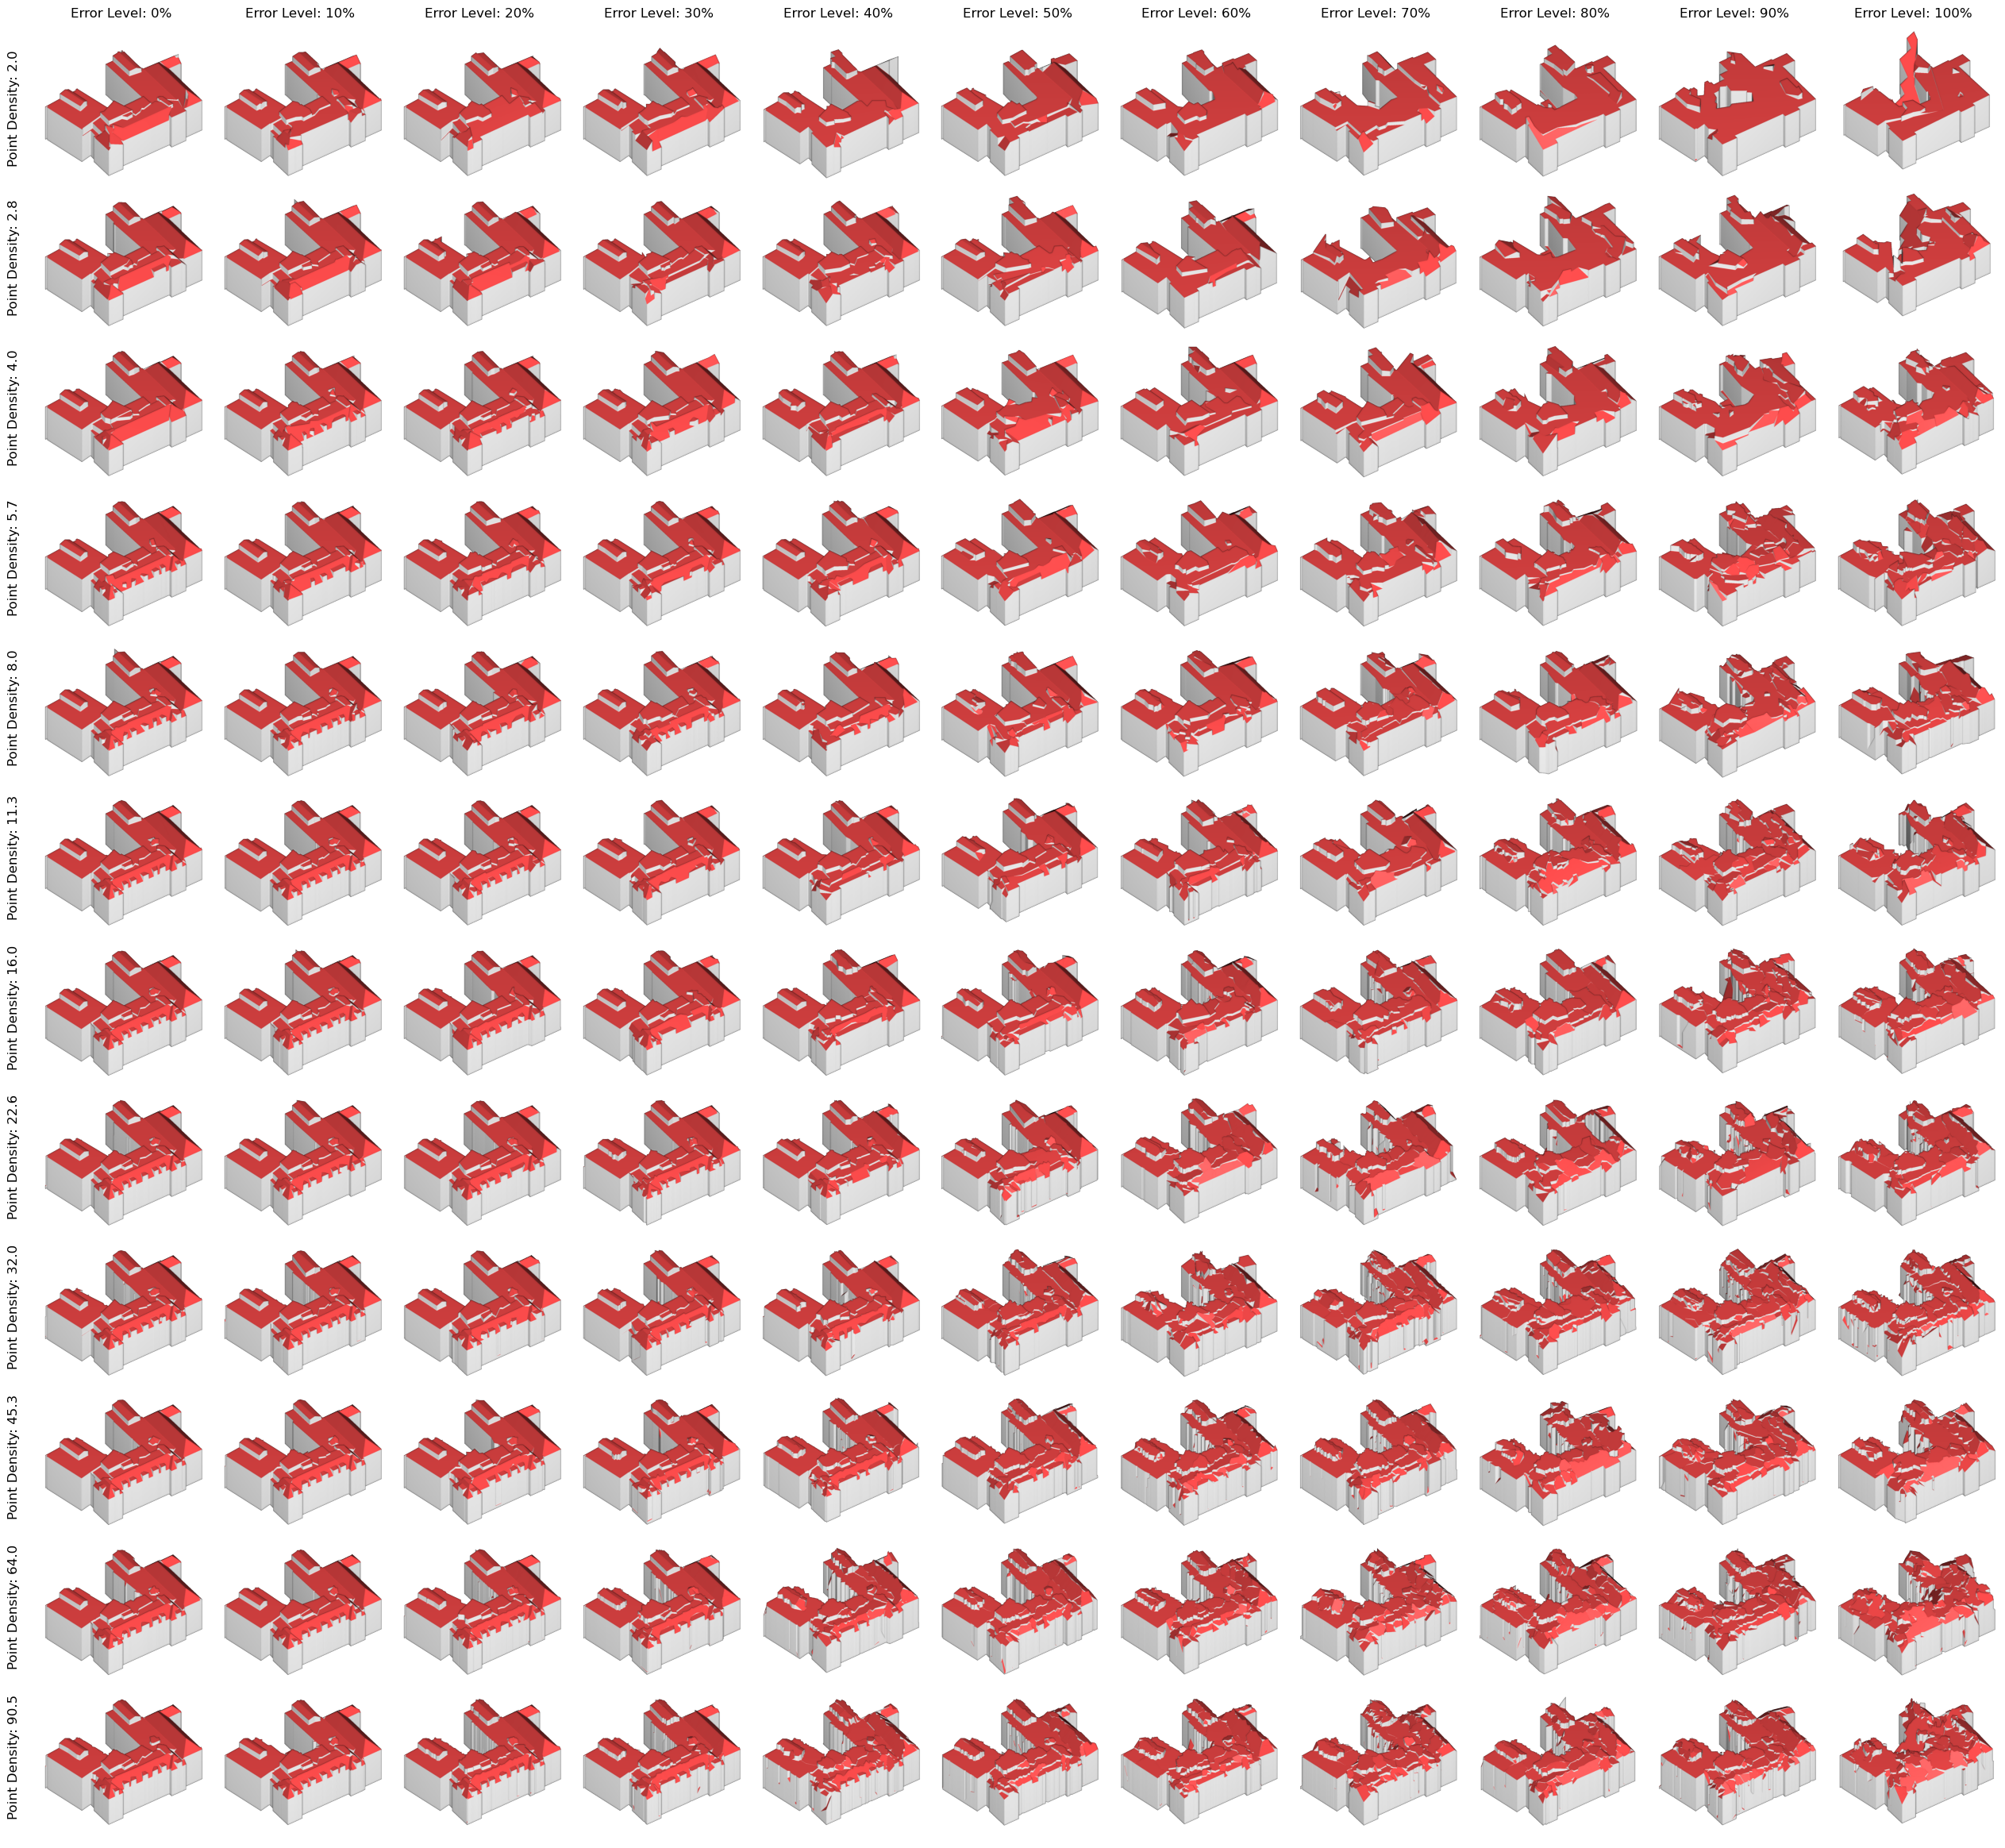

In [18]:
n_rows = 12
n_cols = 11
col_width = 2.3
row_height = 2.3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*col_width, n_rows*row_height))

for i, ax in enumerate(axes.flat):
    img = plt.imread(png_filepaths[i])
    ax.imshow(img)
    ax.set_axis_off()
    
    if i < n_cols:
        ax.set_title(f"Error Level: {i*10}%", fontsize=12, fontweight="normal")
    if i % n_cols == 0:
        row_idx = i // n_cols
        point_density = np.round(2**(row_idx/2 + 1), decimals=1)
        ax.text(-0.1, 0.5, f"Point Density: {point_density}", va='center', ha='right', rotation=90, fontsize=12, transform=ax.transAxes)

plt.tight_layout()

fig.subplots_adjust(hspace=-0.7)

# fig.savefig(f"figures/models_3d_vis_12x11.png", dpi=200, bbox_inches="tight")

plt.show()

In [19]:
fig.savefig(f"figures/models_3d_vis_12x11.png", dpi=200, bbox_inches="tight")

# Development

Rendering scenario_000_lod_22_NL.IMBAG.Pand.0344100000069160.obj ...


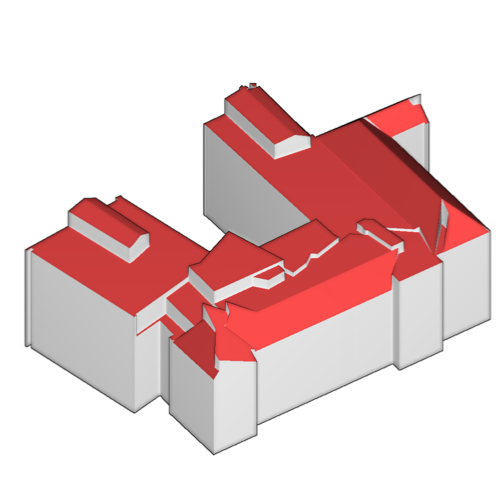

In [15]:
plotter = pv.Plotter(notebook=True, lighting="three lights", window_size=(500, 500))
plotter.enable_eye_dome_lighting()
render_model(
    obj_filepaths[0],
    mtllib_filepath,
    pos,
    return_img=False,
    show=True,
    png_filepath=png_filepaths[0]
)

C:\Users\Florian\Data\city-to-scan-to-city\utrecht_10-492-594_v2\09_visualization\NL.IMBAG.Pand.0344100000069160\png_22\input_lod_22_NL.IMBAG.Pand.0344100000069160.png
1.35


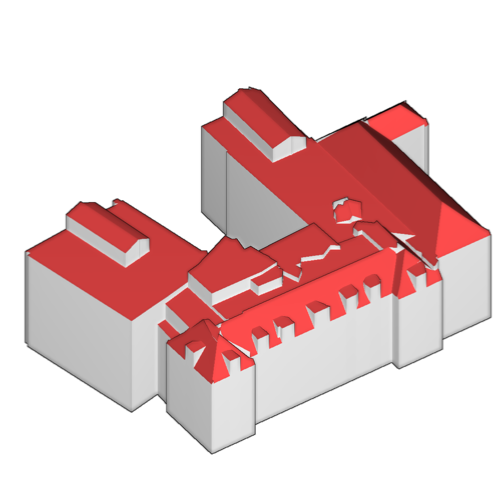

In [13]:
obj_filepath = input_obj_filepath
png_dirpath = e.dirpath / "09_visualization" / identificatie / f"png_{lod}"
png_dirpath.mkdir(exist_ok=True)

png_filepath = png_dirpath / (obj_filepath.stem + ".png")
print(png_filepath)

pv.set_plot_theme(themes.DocumentProTheme())

plotter = pv.Plotter(notebook=True, lighting="three lights", window_size=(500, 500))
plotter.import_obj(obj_filepath, mtllib_filepath)

# plotter.add_light(light=pv.Light(light_type="scene light"))

x = -0.45
y = -0.9
z = 0.9

plotter.set_position((x, y, z))
plotter.set_focus((0, 0, 0))
plotter.set_viewup([0, 0, 1])

# plotter.view_xy()

plotter.enable_eye_dome_lighting()
# plotter.enable_shadows()
# plotter.enable_ssao()
plotter.enable_parallel_projection()
# plotter.show_axes()

# plotter.set_background("grey")

plotter.zoom_camera(1.20)

print(np.sqrt(sum([c**2 for c in (x, y, z)])))

plotter.show(jupyter_backend="static")

img = plotter.screenshot(png_filepath)

In [ ]:
for obj_fp in obj_filepaths.values():
    

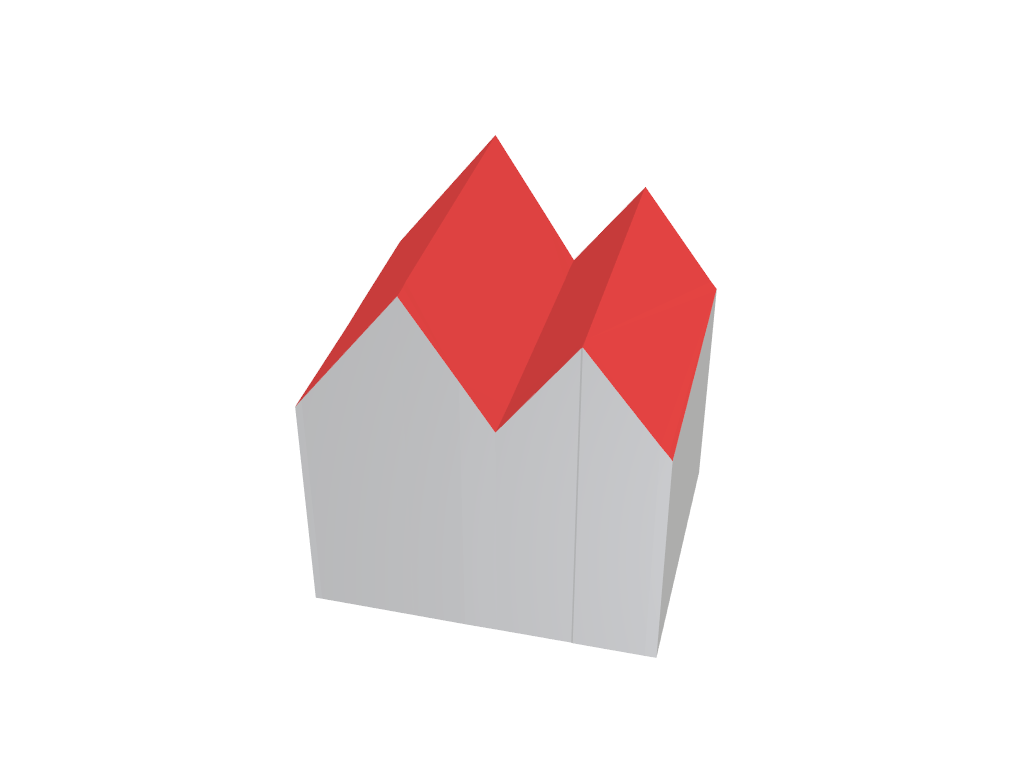

In [90]:
plotter = pv.Plotter(notebook=True)

obj_file = r"C:\Users\Florian\Data\city-to-scan-to-city\utrecht_10-492-594_v2\07_reconstruction\scenario_000\output\model_lod22\_NL.IMBAG.Pand.0344100000018822.obj"
mat_file = r"obj_materials_pyvista.mtl"
# obj_file = r"C:\Users\Florian\Data\city-to-scan-to-city\utrecht_10-492-594_v2\07_reconstruction\scenario_055\output\model_lod22\NL.IMBAG.Pand.0344100000069160.obj"
# mat_file = r"C:\Users\Florian\Data\city-to-scan-to-city\utrecht_10-492-594_v2\07_reconstruction\scenario_000\output\model_lod22\model_lod22.obj.mtl"

# mesh = pv.read(obj_file)

# plotter.add_mesh(mesh)

plotter.import_obj(obj_file, mat_file)

# print(plotter.camera_position)

# pos = plotter.camera_position

plotter.set_position((-1, -1, 1))
plotter.set_focus((0, 0, 0))
plotter.set_viewup([0, 0, 1])
# plotter.view_xy()
#     [(136817.83210027812, 455620.258161523, 136.49013610746988),
#      (136882.2265625, 455694.453125, 13.508260369300842),
#      (0.3254549744966264, 0.7245549909170701, 0.6075352868044496)]
# )

plotter.show(jupyter_backend="static")
# 
# plotter.show()